In [1]:
import pickle, os, sys
import numpy  as np
import seaborn as sns
import mof
import rpxdock as rp


PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [11]:
def analyze_clusters_radii(info):
   assert info.nres.min() == info.nres.max(), 'can only cluster same size pepts'
   nresults = info.sizes['result']
   nres = info.nres.data[0]
   bbcoord = info.bbcoords.data[:, :nres]
   bbcoord_flat = bbcoord.reshape(nresults, -1)
   print('cluster info:')
   print(f'radius: {0:5.3f} nunique {nresults:7,}')
   radius = 0.25
   while radius < 10:
      centers = rp.cluster.cookie_cutter(bbcoord_flat, radius)
      print(f'radius: {radius:5.3f} nunique {len(centers):7,}')
      radius *= 2

def extract_cluster_centers(info, radius):
   if radius is 0: return info
   assert info.nres.min() == info.nres.max(), 'can only cluster same size pepts'
   nresults = info.sizes['result']
   nres = info.nres.data[0]
   bbcoord = info.bbcoords.data[:, :nres]
   bbcoord_flat = bbcoord.reshape(nresults, -1)
   centers = rp.cluster.cookie_cutter(bbcoord_flat, radius)
   return info.isel(result=centers)

def get_unique_sequences(info):
   sequence_counts = [(s, x.sizes['result']) for s, x in info.groupby('sequence')]
   unique = [s for s, x in sequence_counts if x == 1]
   # print(unique)
   uinfo = info.sel(result=info.sequence.isin(unique))
   return uinfo

In [8]:
info = rp.load('/home/sheffler/debug/mof/doubleres2/scaffolds_c3/results/mof_doubleres_c2c3_9res_combined_info_files.pickle')

In [19]:
print('the info is an xarray.Dataset:')
print(type(info))

the info is an xarray.Dataset:
<class 'xarray.core.dataset.Dataset'>


In [23]:
print('printing the dataset tells you all kinds of stuff about it')
print(info)

printing the dataset tells you all kinds of stuff about it
<xarray.Dataset>
Dimensions:                     (hcol: 4, hrow: 4, ncac: 3, resi: 10, result: 10742, xyz: 3)
Dimensions without coordinates: hcol, hrow, ncac, resi, result, xyz
Data variables:
    score                       (result) float64 -59.55 -59.1 ... 39.94 39.95
    score_fa_atr                (result) float64 -19.94 -19.98 ... -27.24 -19.22
    score_fa_rep                (result) float64 13.66 14.73 ... 30.0 19.04
    score_fa_sol                (result) float64 29.96 29.7 ... 39.51 22.76
    score_lk_ball               (result) float64 51.77 51.09 ... 62.58 36.36
    score_fa_elec               (result) float64 -125.2 -121.6 ... -77.08 -55.9
    score_hbond_sr_bb           (result) float64 -4.819 -4.799 ... -1.983 0.0
    score_dslf_fa13             (result) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    score_atom_pair_constraint  (result) float64 9.226 7.195 ... 24.11 22.55
    score_angle_constraint      (result) fl

In [28]:
print('this dataset has several dimensions, but mostly you will care about the "result" dimension')
print(info.sizes)
print()
print('*result* is like the rows in a pandas data frame -- the main dimension we care about')
print('*hrow* and *hcol* are the 4x4 transform dimensions')
print('*resi* *ncac* and *xyz* are the dimension alow which backbone coords are stored')
print()
print('resi is padded to length 10 to preserve dataset compatibility across runs with different size peptides')

this dataset has several dimensions, but mostly you will care about the "result" dimension
Frozen(SortedKeysDict(OrderedDict([('result', 10742), ('hrow', 4), ('hcol', 4), ('resi', 10), ('ncac', 3), ('xyz', 3)])))

*result* is like the rows in a pandas data frame -- the main dimension we care about
*hrow* and *hcol* are the 4x4 transform dimensions
*resi* *ncac* and *xyz* are the dimension alow which backbone coords are stored

resi is padded to length 10 to preserve dataset compatibility across runs with different size peptides


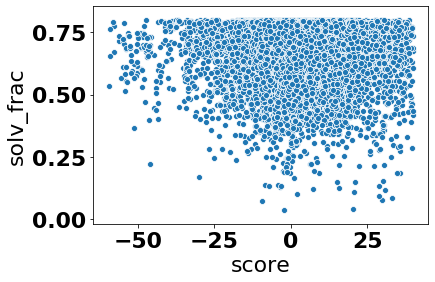

In [9]:
sns.scatterplot(info.score,info.solv_frac)

In [18]:
print('the best scoring structure')
print(info.fname[np.argmin(info.score)].data)

the best scoring structure
results/mofdock_asym_c.1.4_0001_I_21_3_hit_DASP_HIS_3_1_7_cell029_ncontact24_score-16.pdb


In [15]:
print('reorder dataset by overall score')
info = info.sortby('score')

reorder dataset by overall score


In [16]:
print('now best scoring is the first')
print(info.fname.data[0])

now best scoring is the first
results/mofdock_asym_c.1.4_0001_I_21_3_hit_DASP_HIS_3_1_7_cell029_ncontact24_score-16.pdb


In [13]:
print('most compact xtal:')
print(info.fname[np.argmin(info.solv_frac)].data)

most compact xtal:
results/mofdock_asym_c.5.8_0001_I_21_3_hit_DGLU_DHIS_D_2_9_557_cell024_ncontact24_score011.pdb


In [42]:
print('num results by  spacegroup')
print(f'{"total":>10} {info.sizes["result"]:7,}')
for spacegroup, x in info.groupby('spacegroup'):
    print(f'{spacegroup:>10} {x.sizes["result"]:7,}')

num results by  spacegroup
     total  10,742
    I 21 3   9,331
  P 41 3 2   1,072
  P 43 3 2     339


In [46]:
print('sequences with only one xtal form (takes a sec to run...)')

print('total number of sequences', len(np.unique(info.sequence.data)))
for radius in [0.0, 0.5, 1, 2, 4, 8, 16]:
    cinfo = extract_cluster_centers(info, radius)
    uinfo = get_unique_sequences(cinfo)
    print(f'nunique by clust radius: {radius:7.3f} unique seqs: {uinfo.sizes["result"]:5,}')

sequences with only one xtal form (takes a sec to run...)
total number of sequences 137
nunique by clust radius:   0.000 unique seqs:    12
nunique by clust radius:   0.500 unique seqs:    12
nunique by clust radius:   1.000 unique seqs:    13
nunique by clust radius:   2.000 unique seqs:    10
nunique by clust radius:   4.000 unique seqs:    11
nunique by clust radius:   8.000 unique seqs:    23
nunique by clust radius:  16.000 unique seqs:    26


In [50]:
print('pbd filenames of unique sequences clustered at 1.0A backbone rmsd')
cluster_center_info = extract_cluster_centers(info, radius=1.0)
unique_seq_info = get_unique_sequences(cluster_center_info)
for fname in unique_seq_info.fname.data:
    print(fname)

pbd filenames of unique sequences clustered at 1.0A backbone rmsd
results/mofdock_asym_c.10.2_0001_I_21_3_hit_DCYS_DASP_1_2_39_cell027_ncontact21_score-15.pdb
results/mofdock_asym_c.10.8_0001_I_21_3_hit_DCYS_DASP_3_4_38_cell025_ncontact45_score013.pdb
results/mofdock_asym_c.1.4_0001_I_21_3_hit_DCYS_DGLU_3_2_24_cell026_ncontact18_score032.pdb
results/mofdock_asym_c.1.1_0001_P_41_3_2_hit_DCYS_DGLU_3_1_68_cell034_ncontact12_score-13.pdb
results/mofdock_asym_c.4.8_0001_P_41_3_2_hit_CYS_DASP_2_3_86_cell037_ncontact05_score018.pdb
results/mofdock_asym_c.6.2_0001_I_21_3_hit_CYS_GLU_3_1_0_cell031_ncontact10_score008.pdb
results/mofdock_asym_c.4.8_0001_I_21_3_hit_CYS_DGLU_2_3_4_cell037_ncontact03_score-01.pdb
results/mofdock_asym_c.4.8_0001_P_41_3_2_hit_CYS_DHIS_D_2_3_14_cell034_ncontact12_score-26.pdb
results/mofdock_asym_c.5.3_0001_I_21_3_hit_CYS_DHIS_D_1_2_44_cell037_ncontact14_score005.pdb
results/mofdock_asym_c.1.5_0001_I_21_3_hit_CYS_ASP_3_4_42_cell036_ncontact17_score-11.pdb
results/mofd